Importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from keras.optimizers import Adam
import cv2
import os
from google.colab.patches import cv2_imshow

Preparing data and folders

In [ ]:
if(os.path.isdir('/content/training_data') == False):
  os.mkdir('/content/training_data')
if(os.path.isdir('/content/testing_data') == False):
  os.mkdir('/content/testing_data')

_train_data_url_ = 'https://raw.githubusercontent.com/aaaaqa/face-detection/testing/train_data.zip'
_test_data_url_ = 'https://raw.githubusercontent.com/aaaaqa/face-detection/testing/test_data.zip'
!wget -P /content/training_data '{_train_data_url_}'
!wget -P /content/testing_data '{_test_data_url_}'
!7z x /content/training_data/train_data.zip -o/content/training_data/
!7z x /content/testing_data/test_data.zip -o/content/testing_data/
!rm /content/testing_data/test_data.zip
!rm /content/training_data/train_data.zip

Gathering data into variables

In [ ]:
def _gathering_dataset_(directory):
  return tf.keras.utils.image_dataset_from_directory(directory, batch_size=1, image_size=(48,48), color_mode='grayscale', seed=123)

training_dataset = _gathering_dataset_('/content/training_data/')
train_class_names = training_dataset.class_names
num_classes = len(training_dataset.class_names)

training_dataset = training_dataset.unbatch()
x_train, y_train = list(zip(*training_dataset))

testing_dataset = _gathering_dataset_('/content/testing_data/')
testing_dataset = testing_dataset.unbatch()
x_test, y_test = list(zip(*testing_dataset))

Found 24282 files belonging to 5 classes.
Found 5937 files belonging to 5 classes.


In [ ]:
train_class_names

['angry', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
y_train_ = []
for i in range(len(y_train)):
  y_train_.append(train_class_names[y_train[i]])

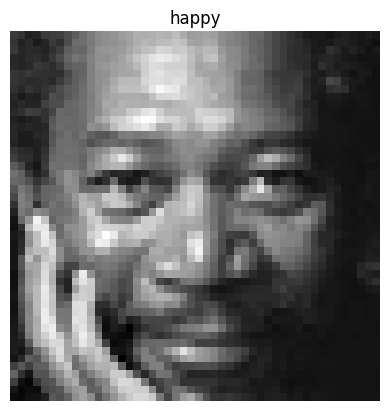

In [ ]:
plt.imshow(x_train[0], cmap='gray')
plt.title(y_train_[0])
plt.axis('off')
plt.show()

# Data augmentation

In [ ]:
augmentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.1)])

def preprocess(image):
  image = augmentation_layer(image)
  return image

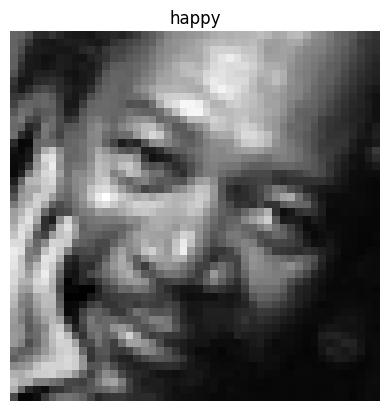

In [ ]:
plt.imshow(augmentation_layer(x_train[0]), cmap='gray')
plt.title(y_train_[0])
plt.axis('off')
plt.show()

In [ ]:
import time

x_train = list(np.array(x_train)/255.)
x_augmentation = x_train
y_train = list(y_train)

for j in range(6):
  for i in range(len(x_train)):
    start = time.time()
    x_train.append(augmentation_layer(x_train[i]))
    #augmented_data = [preprocess(x) for x in x_augmentation]
    #x_train.extend(augmented_data)
    end = time.time()
    print(end - start)
    y_train.extend(y_train)
  print(j+1, " finished")

0.022203683853149414
0.016715288162231445
0.01994466781616211
0.018453598022460938
0.02630448341369629
0.0480349063873291
0.018810749053955078
0.01954936981201172
0.021562576293945312
0.0249481201171875
0.021242618560791016
0.019836902618408203
0.018979549407958984
0.025949716567993164
0.022632360458374023


In [ ]:
import pandas as pd

labels_ = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

In [ ]:
x_train = np.array(x_train)

# Creating model

In [ ]:
model = models.Sequential([
  layers.Conv2D(32,3,input_shape=(48,48,1),activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32,3,activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.3),
  layers.Conv2D(64,3,activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64,3,activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.5),
  layers.Conv2D(128,3,activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128,3,activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128,activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
tf.config.run_functions_eagerly(True)
history = model.fit(x_train, labels_, epochs=15, batch_size=256)

Epoch 1/15
247/664 [==========>...................] - ETA: 23:25 - loss: 1.7901 - accuracy: 0.2619

KeyboardInterrupt: ignored

In [ ]:
score, acc = model.evaluate(x_test, y_test, batch_size=256)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


ValueError: ignored

In [ ]:
_testing_image_ = 'https://previews.123rf.com/images/stylephotographs/stylephotographs1301/stylephotographs130100017/17104891-headshot-of-a-young-happy-smiling-man.jpg'
_testing_path_  = tf.keras.utils.get_file(origin=_testing_image_)

img = tf.keras.utils.load_img(_testing_path_, target_size=(48, 48))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

img_array = tf.image.rgb_to_grayscale(img_array)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence."
.format(train_class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 70ms/step
This image most likely belongs to happy with a 35.17 percent confidence.


In [ ]:
!pip3 install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=558f4fed21a0bae236c62bc53e633468ea312fd21e7f478bec7de244369ebcfd
  Stored in directory: /root/.cache/pip/wheels/22/a8/60/4a2aeb763d63f50190f4c4e07069a22245347eeafdb3a67551
Successfully built face-recognition-models


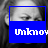

In [ ]:
import face_recognition
from PIL import Image, ImageDraw
image = face_recognition.load_image_file('/content/testing_data/angry/10052.jpg')
face_locations = face_recognition.face_locations(image)
# Find all the faces and face encodings in the unknown image
face_locations = face_recognition.face_locations(image)
face_encodings = face_recognition.face_encodings(image, face_locations)

pil_image = Image.fromarray(image)
draw = ImageDraw.Draw(pil_image)

known_expressions = class_names

# Loop through each face found in the unknown image
for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):

    # Draw a box around the face using the Pillow module
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))
    name='Unknow'
    # Draw a label with a name below the face
    text_width, text_height = draw.textsize(name)
    draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
    draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))


# Remove the drawing library from memory as per the Pillow docs
del draw

# Display the resulting image
pil_image.show()

#_video_capture_ = cv2.VideoCapture(0)

In [ ]:
total_clusters = len(np.unique(_training_dataset_))
kmeans = MiniBatchKMeans(n_clusters = total_clusters)
kmeans.fit(_training_dataset_)

TypeError: ignored

In [ ]:
np_array = np.array(_training_dataset_)
np_array = np_array/255.0

TypeError: ignored

In [ ]:
reshaped_data = data.reshape(len(data),-1)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  image = take_photo()
  print('Saved to {}'.format(image))

  image = cv2.rectangle(image,  , end_point, color, thickness)

# Remove the drawing library from memory as per the Pillow docs
  # Show the image which was just taken.
  display(Image(image))
except Exception as err:
  del draw
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored